# Testando modelo com MTCNN

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import accuracy_score
import os
from PIL import Image
import cv2
from mtcnn import MTCNN

In [12]:
model = load_model('./mobilenetv2_finetuned_fer2013_v2.keras')

In [13]:
# Classes dataset FER2013
emotion_labels = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

In [14]:
# Inicializar o detector MTCNN
detector = MTCNN()

In [15]:
def preprocess_image(image_path, return_cropped_face=False):
    """
    Pré-processa a imagem:
    - Detecta o rosto usando MTCNN
    - Redimensiona para (96, 96)
    - Normaliza os valores de pixel
    - Se return_cropped_face=True, retorna também a imagem do rosto recortado (com shape original do bounding box)
    """
    # Carregar a imagem e converter para RGB
    image = Image.open(image_path).convert("RGB")
    image_array = np.array(image)

    # Detectar rostos
    detections = detector.detect_faces(image_array)

    # Verificar se algum rosto foi detectado
    if not detections:
        print(f"Nenhum rosto detectado em: {image_path}")
        return (None, None) if return_cropped_face else None

    # Selecionar o rosto com maior bounding box
    face = max(detections, key=lambda x: x['box'][2] * x['box'][3])
    x, y, width, height = face['box']
    x, y = max(0, x), max(0, y)

    # Extrair o rosto no formato original do bounding box
    face_img = image_array[y:y+height, x:x+width]
    # Para o modelo, redimensionar para (96, 96)
    face_resized = cv2.resize(face_img, (96, 96))

    # Normalizar e expandir a dimensão para batch
    face_array = face_resized / 255.0
    face_array = np.expand_dims(face_array, axis=0)

    if return_cropped_face:
        return face_array, face_img  # face_img mantém o shape original do bounding box
    else:
        return face_array

In [16]:
def predict_emotion(image_path, true_label=None):
    """
    Realiza a predição de emoção a partir de uma imagem usando MTCNN para detecção de rosto.
    - Retorna a emoção prevista, a confiança e a acurácia.
    """
    # Pré-processar a imagem
    processed_image = preprocess_image(image_path)

    # Se não houver rosto, retorna None
    if processed_image is None:
        return "No face detected", None, None

    # Realizar a predição
    predictions = model.predict(processed_image)
    predicted_index = np.argmax(predictions[0])
    predicted_emotion = emotion_labels[predicted_index]
    confidence = predictions[0][predicted_index]

    # Cálculo da acurácia
    if true_label:
        accuracy = 1.0 if predicted_emotion == true_label else 0.0
    else:
        accuracy = None

    return predicted_emotion, confidence, accuracy


In [17]:
def predict_emotion(image_path, true_label=None):
    """
    Realiza a predição de emoção a partir de uma imagem.
    - Retorna a emoção prevista, a confiança e a acurácia.
    """
    # Pré-processar a imagem
    processed_image = preprocess_image(image_path)

    # Se não houver rosto, retorna None
    if processed_image is None:
        return "No face detected", None, None

    # Realizar a predição
    predictions = model.predict(processed_image)
    predicted_index = np.argmax(predictions[0])
    predicted_emotion = emotion_labels[predicted_index]
    confidence = predictions[0][predicted_index]

    # Calcular a acurácia, se o true_label for fornecido
    if true_label:
        accuracy = 1.0 if predicted_emotion == true_label else 0.0
    else:
        accuracy = None

    return predicted_emotion, confidence, accuracy


In [18]:
import matplotlib.pyplot as plt

def display_results(image_path, predicted_emotion, confidence, accuracy):
    """
    Exibe a imagem juntamente com o resultado da predição.
    """
    # Carregar a imagem
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Exibição
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    
    # Título com informações da predição
    title = f"Predição: {predicted_emotion}\nConfiança: {confidence:.2f}" if confidence else "Sem confiança"
    if accuracy is not None:
        title += f"\nAcurácia: {accuracy:.2f}"
    
    plt.title(title, fontsize=12)
    plt.show()


In [19]:
def process_images(image_folder, true_labels=None):
    """
    Processa imagens em um diretório na ordem alfanumérica e exibe os resultados.
    - image_folder: Diretório contendo as imagens.
    - true_labels: Lista opcional de rótulos verdadeiros.
    """
    # Listar e ordenar imagens alfanumericamente
    image_files = sorted([
        os.path.join(image_folder, f) 
        for f in os.listdir(image_folder) 
        if f.lower().endswith(('.png', '.jpg', '.jpeg'))
    ])

    # Verificar correspondência entre imagens e true_labels
    if true_labels and len(true_labels) != len(image_files):
        raise ValueError("O número de rótulos verdadeiros não coincide com o número de imagens.")

    for idx, image_path in enumerate(image_files):
        true_label = true_labels[idx] if true_labels and idx < len(true_labels) else None
        
        # Realizar a predição
        predicted_emotion, confidence, accuracy = predict_emotion(image_path, true_label)
        
        # Exibir os resultados
        display_results(image_path, predicted_emotion, confidence, accuracy)

2025-05-26 11:31:44.954378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


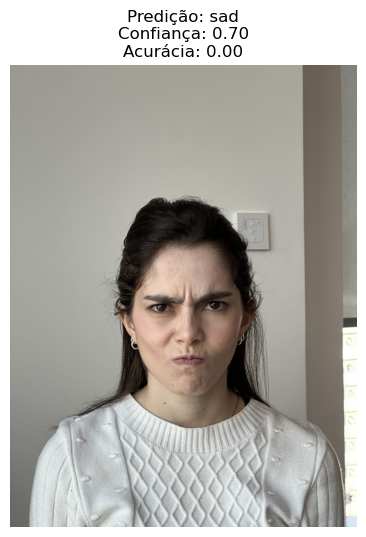

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


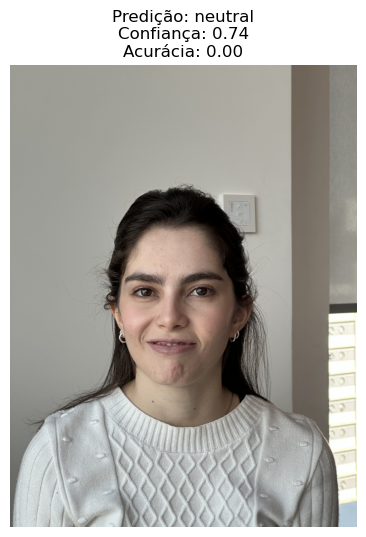

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


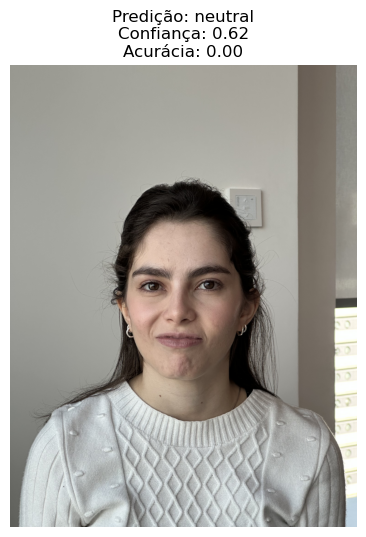

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


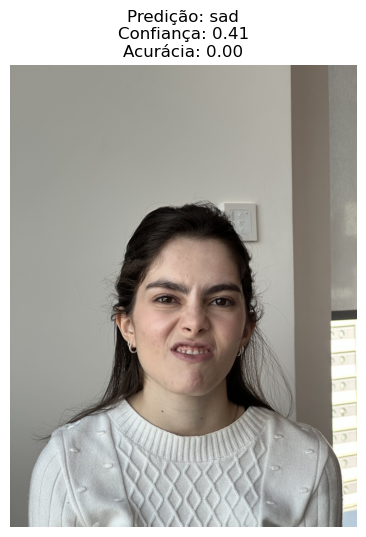

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


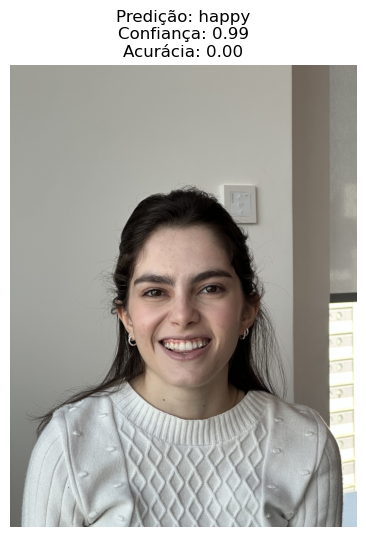

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


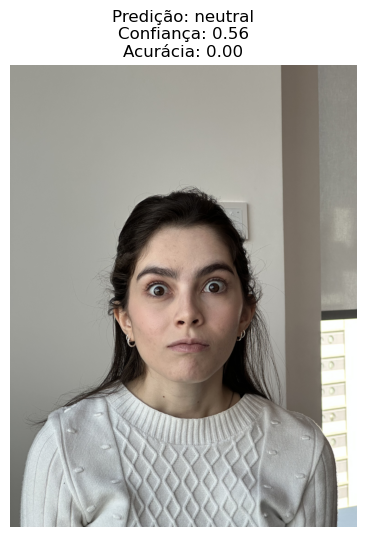

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


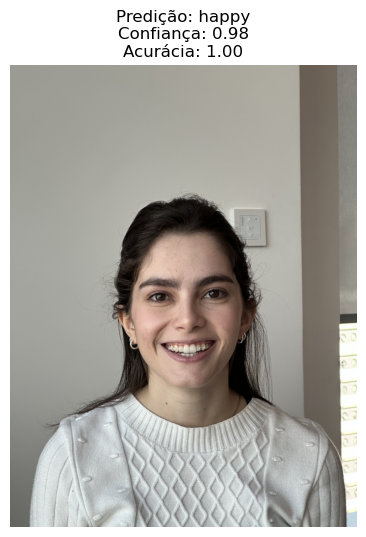

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


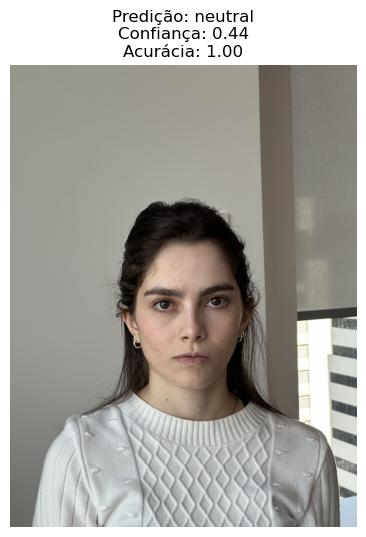

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


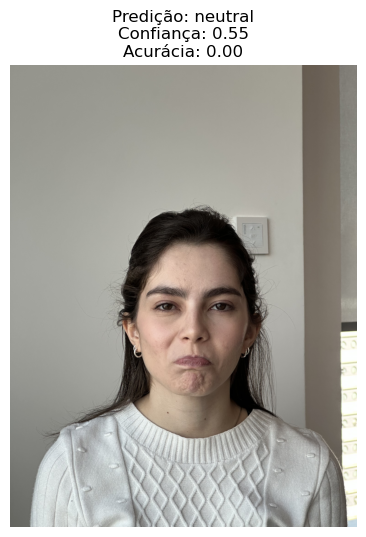

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


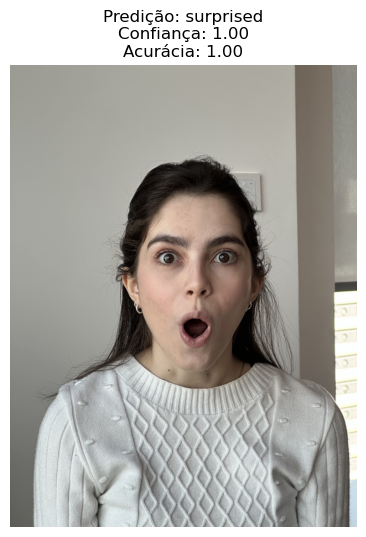

In [20]:
# Exemplo de uso:
image_folder = './images3'
true_labels = ['angry', 'disgusted', 'disgusted', 'disgusted', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']  # Opcional
process_images(image_folder, true_labels)